# Aircraft sampling representativeness

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import numpy as np
from scipy.stats import linregress

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import emergent_constraint as ec
import figure_panels
import models
import obs_aircraft
import util

## Load model data

In [3]:
model_list = ['CT2019B'] 
model_objs = {}
for name in model_list:
    model_objs[name] = models.Model(name)
model_objs  

{'CT2019B': <models.core.Model at 0x2b7bd9594050>}

In [4]:
dsets_theta_bins = {}
for model in model_list:
    ds = model_objs[model].open_derived_dataset(
        'molefractions_theta_bins',
        kwargs_name='SO-10K-bins-300K_275K',
        lat_bounds=(-80., -45.),
        theta_bins=[(295., 305.), (270., 280.),],
    )
    dsets_theta_bins[model] = ds.sel(time=slice('2009', '2020')).compute()
dsets_theta_bins    

assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CT2019B/molefractions_theta_bins.SO-10K-bins-300K_275K.nc


{'CT2019B': <xarray.Dataset>
 Dimensions:            (time: 3652, theta_bins: 2, d2: 2)
 Coordinates:
   * time               (time) datetime64[ns] 2009-01-01T12:00:00 ... 2018-12-...
   * theta_bins         (theta_bins) float64 300.0 275.0
     theta_bins_bounds  (theta_bins, d2) float64 295.0 305.0 270.0 280.0
 Dimensions without coordinates: d2
 Data variables:
     CO2                (time, theta_bins) float32 383.7 383.5 ... 406.2 405.9
     Z3                 (time, theta_bins) float32 4.937e+03 669.0 ... 807.7
     P                  (time, theta_bins) float32 5.344e+04 ... 8.992e+04
     T                  (time, theta_bins) float32 249.3 268.7 ... 245.7 267.5
     theta              (time, theta_bins) float32 299.8 275.8 ... 299.8 276.2
     CO2_OCN            (time, theta_bins) float32 -10.24 -10.45 ... -26.17
     CO2_LND            (time, theta_bins) float32 -5.733 -5.565 ... -12.81
     CO2_FFF            (time, theta_bins) float32 31.47 31.31 ... 76.79 76.64
     area    

In [5]:
dsets_theta_bins_lon = {}
for model in model_list:
    ds = model_objs[model].open_derived_dataset(
        'molefractions_theta_bins_sectors',
        kwargs_name='SO-10K-bins-300K_275K',
        lat_bounds=(-80., -45.),
        theta_bins=[(295., 305.), (270., 280.),],
    )
    for v in ds.data_vars:
        if 'time' in ds[v].dims:
            newdims = ['time']  + [d for d in ds[v].dims if d != 'time']
            ds[v] = ds[v].transpose(*newdims)
    dsets_theta_bins_lon[model] = ds.sel(time=slice('2009', '2020')).compute()
dsets_theta_bins_lon    

assuming cache is correct
reading cached file: /glade/u/home/mclong/codes/so-co2-airborne-obs/so-co2-airborne-obs/models/data-cache/CT2019B/molefractions_theta_bins_sectors.SO-10K-bins-300K_275K.nc


{'CT2019B': <xarray.Dataset>
 Dimensions:                (lon_bins: 6, time: 3652, theta_bins: 2, d2: 2)
 Coordinates:
   * lon_bins               (lon_bins) float64 30.0 90.0 150.0 210.0 270.0 330.0
   * time                   (time) datetime64[ns] 2009-01-01T12:00:00 ... 2018...
   * theta_bins             (theta_bins) float64 300.0 275.0
     theta_bins_bounds      (theta_bins, d2) float64 295.0 305.0 270.0 280.0
 Dimensions without coordinates: d2
 Data variables:
     CO2                    (time, lon_bins, theta_bins) float32 383.7 ... 405.8
     Z3                     (time, lon_bins, theta_bins) float32 4.523e+03 ......
     P                      (time, lon_bins, theta_bins) float32 5.674e+04 ......
     T                      (time, lon_bins, theta_bins) float32 254.0 ... 269.1
     theta                  (time, lon_bins, theta_bins) float32 299.9 ... 275.2
     CO2_OCN                (time, lon_bins, theta_bins) float32 -10.19 ... -2...
     CO2_LND                (time, lon

## Compute a smoothed daily-climatology

In [6]:
window = 30 
dsets_theta_diff_clm = {}
dsets_theta_diff_lon_clm = {}
for model in model_list:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)    
        dsets_theta_diff_clm[model] = util.mavg_periodic_ds(
            util.daily_climatology(dsets_theta_bins[model]).diff('theta_bins'), 
            window,
        )
        dsets_theta_diff_lon_clm[model] = util.mavg_periodic_ds(
            util.daily_climatology(dsets_theta_bins_lon[model]).diff('theta_bins'), 
            window,
        )
        
dsets_theta_diff_clm

skipping leap days


skipping leap days


{'CT2019B': <xarray.Dataset>
 Dimensions:            (theta_bins: 1, time: 365, d2: 2)
 Coordinates:
   * theta_bins         (theta_bins) float64 275.0
   * time               (time) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
 Dimensions without coordinates: d2
 Data variables:
     theta_bins_bounds  (theta_bins, d2) float64 -25.0 -25.0
     CO2                (time, theta_bins) float64 -0.5201 -0.5233 ... -0.5165
     Z3                 (time, theta_bins) float64 -4.4e+03 ... -4.406e+03
     P                  (time, theta_bins) float64 3.876e+04 ... 3.88e+04
     T                  (time, theta_bins) float64 21.03 20.98 ... 21.15 21.09
     theta              (time, theta_bins) float64 -23.77 -23.76 ... -23.77
     CO2_OCN            (time, theta_bins) float64 -0.4943 -0.4972 ... -0.4912
     CO2_LND            (time, theta_bins) float64 0.1532 0.1539 ... 0.1523
     CO2_FFF            (time, theta_bins) float64 -0.1792 -0.1804 ... -0.178
     area               (time, theta_bi

In [7]:
clobber = False 
clobber_deep = False
constraint_type = 'ocean_constraint'
campaign_info = obs_aircraft.get_campaign_info(verbose=False)
model_input_lists = ec.get_model_tracer_lists(constraint_type)

obj = ec.whole_enchilada(clobber=clobber_deep, **model_input_lists)
ac = obj.get_ac(**ec.get_parameters('default'), clobber=clobber)

In [8]:
ac.theta_bins

((295.0, 305.0), (-inf, 280.0))

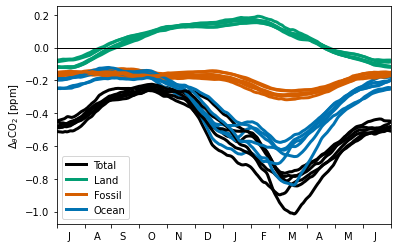

In [9]:
model = 'CT2019B'

figs, axs = util.canvas(1, 1)
for lon_bin in dsets_theta_diff_lon_clm[model].lon_bins.values:
    figure_panels.vertical_gradient_seasonal(
        dsets_theta_diff_lon_clm[model].sel(lon_bins=lon_bin), 
        axs[0, 0], #co2_var_list=['CO2'],
)

In [10]:
df_air_model_flts = ac.get_flight_gradients({model: obj.dfs_model[f'{model}-CO2']})
df_model_camp = ac.get_campaign_gradients({model: obj.dfs_model[f'{model}-CO2']})

In [11]:
campaign_info = obs_aircraft.get_campaign_info(verbose=False)

In [12]:
model = 'CT2019B'
ds_ΔθCO2 = dsets_theta_bins[model].diff('theta_bins')
ΔθCO2_za = {}
for campaign, info in campaign_info.items():
    za_grad = (ds_ΔθCO2.CO2
               .sel(time=slice(info['time_bound'][0], info['time_bound'][1]))
               .mean('time')
              )
    ΔθCO2_za[campaign] = float(za_grad.values)

In [13]:
import cmocean
from matplotlib.colors import rgb2hex
color_lon = {}
bins = dsets_theta_diff_lon_clm[model].lon_bins.values
rgb = cmocean.tools.get_dict(cmocean.cm.phase, N=len(bins)+1)
for name, r, g, b in zip(bins, rgb['red'], rgb['green'], rgb['blue'], ):
    color_lon[name] = rgb2hex([r[1], g[1], b[1]])
color_lon

{30.0: '#a8780d',
 90.0: '#359943',
 150.0: '#1e93a8',
 210.0: '#7d73f0',
 270.0: '#d02fd0',
 330.0: '#d74957'}

## Visualization

/glade/work/mclong/miniconda3/envs/so-co2/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


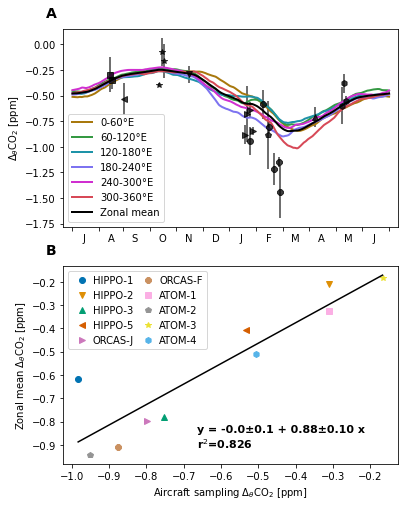

In [14]:
fig, axs = util.canvas(2, 1)

ax = axs[0, 0]
for lon_bin in dsets_theta_diff_lon_clm[model].lon_bins.values:
    ds = dsets_theta_diff_lon_clm[model].sel(lon_bins=lon_bin)
    bnds = ds.coord_lon_bins_bounds.values
    x, y = util.antyear_daily(ds.time, ds.CO2)
    h = ax.plot(x, y, 
                color=color_lon[lon_bin], 
                label=f'{bnds[0]:0.0f}-{bnds[1]:0.0f}°E',
                linestyle='-', 
                linewidth=2
               )   

ds = dsets_theta_diff_clm[model]
x, y = util.antyear_daily(ds.time, ds.CO2)    
h = ax.plot(x, y, 
            color='k',          
            label=f'Zonal mean',
            linestyle='-', 
            linewidth=2
           )   
figure_panels.obs_theta_gradient(df_air_model_flts, ax, just_the_median=True, median_size=6)
ax.set_xlim((-10, 375))
ax.set_xticks(figure_panels.bomday)
ax.set_xticklabels([f'        {m}' for m in figure_panels.monlabs_ant]+[''])
ax.set_ylabel('$\Delta_{ θ}$CO$_2$ [ppm]')
#ax.set_ylim(axs[0, 0].get_ylim())
ax.set_xlim((-10, 375))
ax.legend(loc='lower left');


ax = axs[1, 0]
marker_spec = figure_panels.marker_spec_campaigns()
X = []
Y = []
for c in campaign_info.keys():
    x, y = df_model_camp.loc[c].gradient_mean, ΔθCO2_za[c]
    ax.plot(x, y, **marker_spec[c], label=c, linestyle='None')
    X.append(x); Y.append(y)

ax.legend(loc='upper left', ncol=2, columnspacing=0.4, handletextpad=0.1)    

slope, intercept, r_value, p_value, stderr = linregress(X, Y)
fit = util.regress(X, Y)

x = np.array([np.array(X).min(), np.array(X).max()])
ax.plot(x, x*fit.slope + fit.intercept, 'k-');
ax.set_ylabel('Zonal mean $\Delta_{ θ}$CO$_2$ [ppm]');
ax.set_xlabel('Aircraft sampling $\Delta_{ θ}$CO$_2$ [ppm]');

str_text = (
    f'y = {fit.intercept:0.1f}±{fit.stderr_beta[0]:0.1f} + {fit.slope:0.2f}±{fit.stderr_beta[-1]:0.2f} x\n' + 
    f'r$^2$={fit.r2:0.3f}'
)
xoff = -np.diff(ax.get_xlim()) * 0.6
yoff = np.diff(ax.get_ylim()) * 0.08
ax.text(
    ax.get_xlim()[1]+xoff, ax.get_ylim()[0]+yoff, 
    str_text, 
    fontsize=11, fontweight='bold',
    bbox=dict(facecolor='w', alpha=0.75, edgecolor='None', boxstyle='square,pad=0'),
);

util.label_plots(fig, [ax for ax in axs.ravel()])
util.savefig('seasonal-cycle-zonal-representativeness')